In [1]:
import pandas as pd
import numpy as np

##### Data Preparation

In [2]:
dataset = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
dataset.columns = ['review', 'label']
print(dataset.shape)

(1000, 2)


In [3]:
dataset.sample(10)

,review,label
623,a drive thru means you do not want to wait aro...,0
548,The desserts were a bit strange.,0
530,Everything was good and tasty!,1
285,Great Pizza and Salads!,1
103,I LOVED their mussels cooked in this wine redu...,1
273,Stopped by this place while in Madison for the...,1
277,The goat taco didn't skimp on the meat and wow...,1
109,Sooooo good!!,1
877,Go To Place for Gyros.,1
496,The pancake was also really good and pretty la...,1


In [31]:
print((dataset['label'] == 0).sum())
print((dataset['label'] == 1).sum())

500
500


In [4]:
#B1) Presence of unusual characters (emojis, non-English characters)
#quick research on StackOverflow How to remove row completely when removing non-ascii characters? 
import re
unusual_char = dataset['review'].str.contains(r'[^\x00-\x7F]', regex=True)
dataset[unusual_char]

,review,label
150,My fiancé and I came in the middle of the day ...,1
598,I really enjoyed Crema Café before they expand...,1
823,The crêpe was delicate and thin and moist.,1
915,The only thing I wasn't too crazy about was th...,0


In [5]:
#B1) Vocabulary Size
#Stackoverflow What does Keras Tokenizer method exactly do?
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['review']) #read each word in review column and create dictionary

vocab_size = len(tokenizer.word_index) + 1  #start with index 1 because 0 is reserved
vocab_size  #it found 2072 unique words

2072

In [6]:
#B1) word embedding length
embedding_dim = 100  # common lengths are 50, 100, 200, 300

In [7]:
#B1) statistical justification for the chosen maximum sequence length
review_lengths = dataset['review'].apply(lambda x: len(x.split()))  #for each review count the words
print(review_lengths.describe())
print(int(review_lengths.quantile(0.90))) #calculate 90th percentile
print(int(review_lengths.quantile(0.95))) #calculate 95th percentile

# the mean of review is 10.89 words, the min is 1, the max is 32, 90th percentile says 20 and 95th percentile says 23
# setting the max sequence length to be 23, this covers 95% of the reviews 

max_seq_len = 23

count    1000.000000
mean       10.894000
std         6.260028
min         1.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        32.000000
Name: review, dtype: float64
20
23


In [8]:
#B3) padding process
#Stackoverflow tokenizer.texts_to_sequences Keras Tokenizer gives almost all zeros
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(dataset['review']) #Convert text to sequences of integers (aka text sequence) 
print(sequences[0])
padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='pre')  #padding sequence
padded_sequences[0]

[428, 165, 8, 15]


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 428, 165,   8,  15])

In [9]:
#Train Test Validation split
from sklearn.model_selection import train_test_split

labels = dataset['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42) #first split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) #second split

# from the original dataset 70% training, 15% test, 15% validation

In [10]:
# B6) provide copy of the prepared dataset
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)

np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

##### The Model

In [11]:
print(vocab_size)
print(embedding_dim)
print(max_seq_len)

2072
100
23


In [17]:
# the Model
#Medium Mastering Word Embedding Layers in Keras for Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_seq_len))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 23, 100)             │         207,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 249,505 (974.63 KB)

 Trainable params: 249,505 (974.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))
history

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5365 - loss: 0.6914 - val_accuracy: 0.6400 - val_loss: 0.6804
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7159 - loss: 0.6576 - val_accuracy: 0.7000 - val_loss: 0.6025
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8010 - loss: 0.5060 - val_accuracy: 0.7333 - val_loss: 0.5183
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9283 - loss: 0.3130 - val_accuracy: 0.7600 - val_loss: 0.4672
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9567 - loss: 0.1500 - val_accuracy: 0.8133 - val_loss: 0.4530
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9892 - loss: 0.0767 - val_accuracy: 0.8133 - val_loss: 0.5155
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9911 - loss: 0.0451 - val_accuracy: 0.8000 - val_loss: 0.6004
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9980 - loss: 0.0241 - val_accuracy: 0.8067 - v

##### Model Evaluation

In [19]:
#predictions
val_preds = (model.predict(X_val) > 0.5).astype("int32") #against validation
test_preds = (model.predict(X_test) > 0.5).astype("int32") #against the test

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [23]:
#classification report
from sklearn.metrics import classification_report

print('Validation set')
print(classification_report(y_val, val_preds))
print('Classification set')
print(classification_report(y_test, test_preds))

Validation set
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        73
           1       0.82      0.78      0.80        77

    accuracy                           0.80       150
   macro avg       0.80      0.80      0.80       150
weighted avg       0.80      0.80      0.80       150

Classification set
              precision    recall  f1-score   support

           0       0.77      0.76      0.76        79
           1       0.74      0.75      0.74        71

    accuracy                           0.75       150
   macro avg       0.75      0.75      0.75       150
weighted avg       0.75      0.75      0.75       150



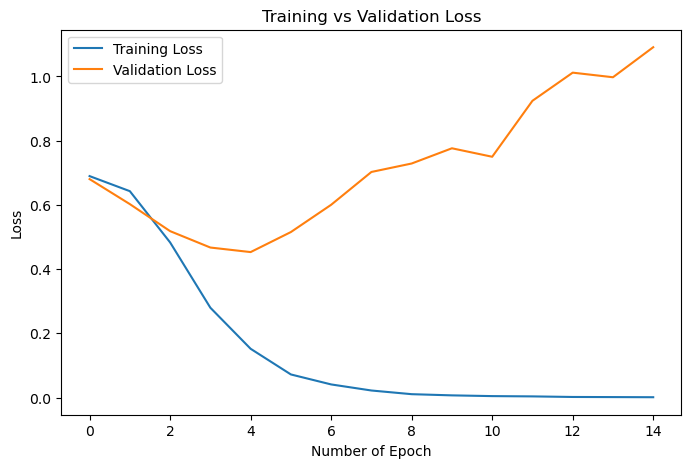

In [24]:
#D3) Training vs Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

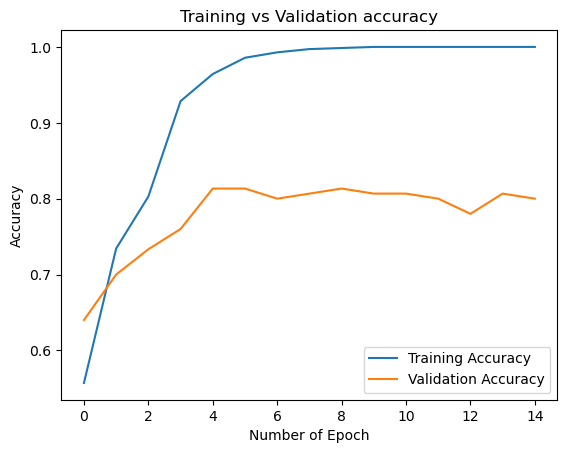

In [26]:
#D4) Training vs Validation Accuracy
# Machine Learning Mastery Display Deep Learning Model Training History in Keras
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training vs Validation accuracy')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
#D5) Save the model
model.save("sentiment_analysis.h5")
